### Overview of the notebook

1. [Motivation](#chapter1)
2. [Basic statistics](#chapter2)<br>
    2.1 [Cleaning and pre-processing the data](#section_2_1)<br>
    2.2 [Discussion of dataset statistics ](#section_2_2)<br>
3. [Basic statistics](#chapter3)<br>
    3.1 [Communities](#section_3_1)<br>
    3.2 [Network visualization with Gephi](#section_3_2)<br>
    3.3 [Sentiment analysis](#section_3_3)<br>
    3.4 [TF-IDF](#section_3_4)<br>
    3.5 [Word-clouds](#section_3_5)<br>
4. [Discussion](#chapter4)
5. [Reference](#chapter5)
6. [Contributions](#chapter6)

# 1. Motivation <a class="anchor" id="chapter1"></a>

**The motivation:** When we think of Disney films, we feel a rush of nostalgia, as if we were watching one of those with a bowl of cereal on a Sunday morning. Therefore, it was an easy decision to take a further look into the villains of Disney, and explore the characters in a new light.

**The dataset:** The dataset was extracted from the Disney Fandom Wiki webpage, and it contains all the character villains from Dinsey. That includes characters from different universes, e.g Marvel, Pixar, Star Wars, Walt Disney and other. After having built and visualized the network, we decided to narrow the scope and maintaining at least some possibility of analysing information about the dataset, do to lack of internal connections in the whole Disney Villains dataset. We then chose to select a subset of the data, that represents one universe, Marvel. 

**The goal:** The goal of the project was to find somthing interesting in the dataset. 

we thought it would be interesting to to use the text-analysis tools we have learned in the course on quotes. (ATH - KLÁRA) 


#### Imports

In [1]:
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import urllib.request
import json
import re
import os
import collections

from fa2 import ForceAtlas2
from matplotlib.lines import Line2D
import wordcloud
from PIL import Image
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import community
import csv

#### Helper functions to get the data

* `load_dataframe`: Reads the csv file, that contails all the villains from disney, and returns a DataFrame.
* `get_path`: Returns the path to the folder that the description txt files are placed.
* `read_data`: Reads the descriptions txt files and returns the description.
* `get_universe`: Finds what universe each villain is a part of. (LAGA)
* `merge_dataframes`: Returns a DataFrame with villains and corresponding universes.
* `get_quotes`: Finds all the quotes each villain has.
* `get_hyperlinks`: Finds all the links that connect the villains together

In [2]:
def load_dataframe(url):
    characters_df = pd.read_csv(url, sep = ';')
    return characters_df

In [3]:
# Get the path for the folder that we keep the descriptions in 
def get_path(name_of_folder):
    script_path = os.getcwd()
    folder = name_of_folder
    path = os.path.join(script_path,folder)
    return path

In [4]:
def read_data(path, char):
    with open(path + char + '.txt', 'r') as f:
        node_description = f.read()
    return node_description

In [5]:
def get_category(characters_df, pat):
    path = get_path('Villains2/')                        
    
    pattern = pat
    
    categories = []
    for char in characters_df.name_of_villains.values:
        # open the description files
        node_description = read_data(path, char)   
        
        find_categories = []
        for p in pattern:
            find_categories += re.findall(p, node_description)
            
        for cat in find_categories:
            categories.append((char, cat))

    return categories

In [6]:
def merge_and_clean_dataframe(col, category, pattern, characters_df):
    df = pd.DataFrame(set(category))
    df['name_of_villains'] = df[0]
    del df[0]
    df[col] = df[1]
    del df[1]
    df_villains_merged = pd.merge(characters_df, df, on='name_of_villains', how='left')
    return df_villains_merged

In [7]:
# Get the quotes in the DataFrame
def get_quotes(df_villains):
    path = get_path('Villains2/')
    
    quotes_pattern = '\{\{Quote\|(.*?)[\[\[(.*?)\]\]]?(?:\|.*?)\}\}'

    quotes = []
    for char in df_villains.name_of_villains.values:
        # open the description files
        node_description = read_data(path, char)
        
        find_quotes = re.findall(quotes_pattern, node_description)
            
        for q in find_quotes:
            quotes.append((char, q))

    return quotes

In [8]:
# Get the hyperlinks
def get_hyperlinks(df_villains):
    path = get_path('Villains2/')
    
    pattern = '\[\[(.*?)(?:\|.*?)?\]\]'
    links = []
    for char in df_villains.name_of_villains.values:
        # open the zelda description files
        node_description = read_data(path, char)
    
        links_square = re.findall(pattern, node_description)
   
        # For pattern including square brackets  
        for name in links_square:
            # check if character is in the char list
            if name in df_villains.name_of_villains.values:
                links.append((char, name))
            else:
                continue
    return links

#### Importing dataset

In [9]:
characters_df = load_dataframe('name_of_villains_4.csv')

In [10]:
# Get the corresponding universes
universe_pattern = ['\[\[Category:(Marvel) Cinematic Universe characters\]\]',
                        '\[\[Category:(Marvel) Comics\]\]',
                        '\[\[Category:(Marvel) Comics characters\]\]',
                        '\[\[Category:(Pixar) characters\]\]',
                        '\[\[Category:(Disney) characters\]\]',
                        '\[\[Category:(Star Wars) characters\]\]',
                        '\[\[Category:(Star Wars) villains\]\]']

universe = get_category(characters_df, universe_pattern)
characters_df = merge_and_clean_dataframe('Universe', universe, universe_pattern, characters_df)

# If we have a nan value the character has no known universe
characters_df = characters_df.fillna('Unkown')
    
# In the dataframe few characters have two universes
# sort them in a way that dinsney comes first and then delete the duplicates of the first column
# this way the charcters will not belong to disney anymore
characters_df = characters_df.sort_values('Universe')
characters_df = characters_df.drop_duplicates(subset='name_of_villains', keep="last")

In [11]:
# Get the corresponging organizations - to be able to drop the organizations from our dataframe
org_pattern = ['\[\[Category:(Organizations)\]\]']
organization = get_category(characters_df, org_pattern)
characters_df = merge_and_clean_dataframe('Org', organization, org_pattern, characters_df)

In [12]:
# Only keep the characters who are not an organization
characters_df = characters_df[characters_df.Org != 'Organizations']
# Then drop organization column
characters_df = characters_df.drop('Org', 1)

In [13]:
links = get_hyperlinks(characters_df)

# 2. Basic statistics <a class="anchor" id="chapter2"></a>

Let's examine some basic statistic before we go further into preprocessing the data. This includes:

* Number of disney villains that are in the dataset
* Number of directed links
* Number of different universes that are extracted from the text analysis

In [14]:
print('There are', len(characters_df), 'Disney villains,', len(links), 'directed links and', 
      len(set(characters_df['Universe'])), 'different universes in our dataset')

There are 2748 Disney villains, 9945 directed links and 5 different universes in our dataset


## 2.1 Cleaning and pre-processing the data <a class="anchor" id="section_2_1"></a>

We are interested in visualizing the network, as well as performing analysis on the data further on in this notebook. Therefore we must do a lot of cleaning on the data. 



The text for all the villains included a lot of different content, for example, words, numbers and special charactes. Therefore we had to make a few patterns to remove the elements we did not want our clean text to consist of. The functionality of the patterns is as follows:

* Remove external links - that link to another part of the fandom website
* Remove images in a gallery
* Remove infobox - that includes backround and character information
* Remove everything inside a curly brackets - that includes links and citations
* Remove titiles and chapter breaks
* Remove titles of paragraphs
* Remove the categories that the character is a part of (we used it in the begining to get the universes, so this will not be needed anymore)
* Remove small numbers - that is citations
* Remove images in the text
* Remove new lines
* Remove special characters
* BÆTA VIÐ
* Replace multiple spaces with one

word cloud = hvaða orð i universes eru áhguaverð- hvaða orð hafa áhrif
sentimental = skoða hvern characters
TF-IDF = clena text fyrir alla characterana

In [15]:
for name in list(characters_df['name_of_villains'].values):
    path = get_path('Villains2/')
    node_description = read_data(path, name)     
    
    node_description = re.sub(r"External links==(.*?)\\n\[\[Category", " ", node_description) # remove external links (links to another part of the fandom website)
    node_description = re.sub(r"Gallery==(.*?)\<\/gallery\>\\n\\n", " ", node_description) # remove gallery (the part with the photos in gallery)
    node_description = re.sub(r"(\{\{.*?)'''", " ", node_description)    # remove infobox (has backround and charactersimformation)   
    node_description = re.sub(r"\{\{(.*?)\}\}", " ", node_description)  # remove curly brackets (links and citations)
    node_description = re.sub(r"==(==.*?==)==", " ", node_description)   # remove titles and chapter breaks
    node_description = re.sub(r"(==.*?==)", " ", node_description)       # remove the name of the paragraphs 
    node_description = re.sub(r"(\[\[Category:.*?\]\])", " ", node_description)   #   remove categories links that we used in the beginng but dont need anymore
    node_description = re.sub(r"(\<\/?ref.*?>)", " ", node_description)      # remove references citations (small numbers)
    node_description = re.sub(r"(\[\[File.*?\|thumb\|.*?\]\])", " ", node_description) #  remove images in text 
    node_description = re.sub(r"(\\n)", " ", node_description)         # remove new line
    node_description = re.sub(r"\W+", " ", node_description)    # remove special characters (keep words and numbers)
    node_description = re.sub(r"\s(one|two|later)\s", " ", node_description)   # remove specific recurrent words, that appear too often
    node_description = re.sub(r"\\s+", " ", node_description)       # replace multiple spaces with one
    
    path = get_path('Clean_text/')
    with open(path + name + '.txt', 'w') as file:
        json.dump(node_description, file)

In [16]:
# Create a list of universes
universe_list = list(set(characters_df['Universe']))
list_of_names = characters_df['name_of_villains'].tolist()

In [17]:
# convert the file names
normal_name = []
comp_name = []
list_of_names = characters_df['name_of_villains'].tolist()
for name in list_of_names:
    if ' ' in name:
        comp_name.append(name)
    else:
        normal_name.append(name)

In [218]:
def get_tokenized_dict(characters_df, column, list_of_column):
    tokenized_dict= {}
    for item in list_of_column:
        final_list = []
        df = characters_df[characters_df[column] == item] # svo ég þurfi ekki að loopa í gegnum allt, heldur bara þegar name samsvarar raceinu sem ég er staðsett í
        for char in df['name_of_villains']:
        
            path = get_path('Clean_text/')
            content = read_data(path, char)  
    
            # hér remove-a composite names -> áður en við tonkenizum
            for name in comp_name:
                content = content.replace(name, "")
        
            tk = RegexpTokenizer(r'\w+') # nota þennan tokenizer til þess að geta removeað punktuation á auðveldan hátt
            token_content = tk.tokenize(content)
    
            # hér remove-a normal names
            words = [word for word in token_content if word not in normal_name]

            # setja allt i lower case
            words = [word.lower() for word in words]
        
            # remove-a stop words
            words = [word for word in words if word not in stopwords.words('english')]
        
            # remove tokens containing numbers
            words = [x for x in words if not any(c.isdigit() for c in x)]
        
    
            wnl = WordNetLemmatizer()
            words = [wnl.lemmatize(word) for word in words]
        
            final_list.extend(words) # passa að yfirskrifa ekki!!!
        tokenized_dict[item] = final_list
    return tokenized_dict


In [219]:
dict_of_universes = get_tokenized_dict(characters_df, 'Universe', universe_list)

## 2.2 Discussion of dataset statistics <a class="anchor" id="section_2_2"></a>

### Features of the network

To get a sense of the data that we are working with, let's look at the entier network and its features. To visualize this, we decided to create a random network with the same amount of nodes and edges as the whole villains network. This was done to compare the degree distribution and check if our intuitions about what we should observe is correct.

In [20]:
# Make a network
villians_network = nx.DiGraph()

# Add egdes
villians_network.add_edges_from(links)

# Discard isolated nodes
villians_network.remove_nodes_from(list(nx.isolates(villians_network)))

In [21]:
# Extract the giant connected component
gcc = villians_network.subgraph(max(nx.weakly_connected_components(villians_network), key=len))

In [22]:
# Lenght of nodes and edges, and the value of p (probability for edge creation)
gcc_nodes = len(gcc.nodes)
gcc_edges = len(gcc.edges)
p = gcc_edges/(gcc_nodes*(gcc_nodes-1))

In [23]:
random_network = nx.fast_gnp_random_graph(gcc_nodes, p, directed=True)

In [24]:
# Find the in and out degree for the villains network
degree_in = list(dict(gcc.in_degree()).values())
degree_out = list(dict(gcc.out_degree()).values())
# Find the degree for the random network
degree_random = list(dict(random_network.degree()).values())

In [25]:
# Find the count of the degrees
degree_count_in = pd.Series(degree_in).value_counts()
degree_count_out = pd.Series(degree_out).value_counts()
degree_count_random = pd.Series(degree_random).value_counts()

In [215]:
# Find the top 5 in-degree
top_indegree = sorted(dict(gcc.in_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 in-degree of the Villains network:\n')
for i in list(top_indegree[:5]):
    print(i[0],'-->',i[1])
print('\n')
# Find the top 5 out-degree
top_outdegree = sorted(dict(gcc.out_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 out-degree of the Villains network:\n')
for i in list(top_outdegree[:5]):
    print(i[0],'-->',i[1])

Top 5 in-degree of the Villains network:

Captain Hook --> 80
Pete --> 73
Maleficent --> 70
Hades --> 63
Jafar --> 60


Top 5 out-degree of the Villains network:

The Overtakers --> 40
Captain Hook --> 33
Cruella De Vil --> 31
Maleficent --> 30
The Evil Queen --> 30


Above we can see the villains that have the highest in- and out-degree. We notice that the highest in-degree is not significant high, compared to the number of nodes in the network.

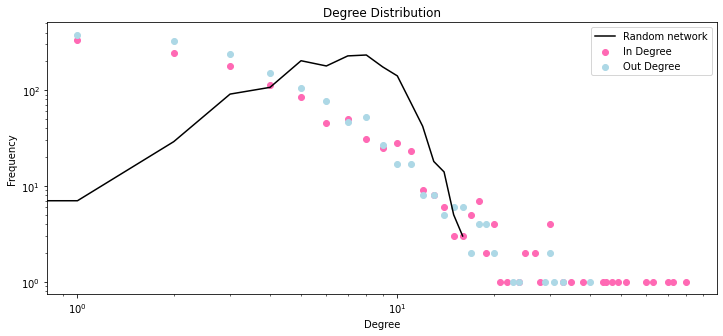

In [27]:
# Plot the in degree, out degree and random network degree
plt.figure(figsize=(12,5))
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
ind = plt.scatter(degree_count_in.index, degree_count_in, color='HotPink')
outd = plt.scatter(degree_count_out.index, degree_count_out, color='lightblue')
rand_argsort = np.argsort(degree_count_random.index)
totd = plt.plot(degree_count_random.index[rand_argsort], degree_count_random.iloc[rand_argsort], color='black')
plt.legend(['Random network','In Degree', 'Out Degree',])
plt.xscale('log')
plt.yscale('log')
plt.show()

From the figure, we see that the in-degree distribution looks a lot like a scale free network, when seen on the log-log plot. Although it is very different from the random network, we also see a slight curve in the distribution so it doesn't perfectly follow a power-law distribution, and therefore we can't declare it as a scale free network. When we look at the out-degree, we see that it is very similar to the in-degree distribution. This is reasonable since the connections in the whole villains network are very sparse, and the charcters have similar amount of in- and out-degree, which encourages us to look further into a specific universe inside the whole villains network. 

Let’s visualize the villains network and see how the connections in between the universes are. 

In [28]:
# Get node positions based on the Force Atlas 2 algorithm
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          edgeWeightInfluence=0.5,
                          # Performance
                          jitterTolerance=0.2, # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=0.6,
                          # Tuning
                          scalingRatio=5.0,
                          strongGravityMode=True,
                          gravity=1,
                          # Log
                          verbose=False)

In [29]:
gcc_undirected = gcc.to_undirected()

In [30]:
degrees = [val for node,val in gcc_undirected.degree()]

# Scale node size according to degree
node_size = [i * 1.6 for i in degrees]

In [31]:
# Get color nodes according to the universe
marvel_df = characters_df.loc[(characters_df['Universe'] == 'Marvel')]
star_wars_df = characters_df.loc[(characters_df['Universe'] == 'Star Wars')]
pixar_df = characters_df.loc[(characters_df['Universe'] == 'Pixar')]
disney_df = characters_df.loc[(characters_df['Universe'] == 'Disney')]
unkown_df = characters_df.loc[(characters_df['Universe'] == 'Unkown')]

color_roles = []
for node in gcc_undirected.nodes():
    if node in marvel_df.name_of_villains.values:
        color_roles.append('#00FF00')
    elif node in star_wars_df.name_of_villains.values:
        color_roles.append('#FF0000')
    elif node in pixar_df.name_of_villains.values:
        color_roles.append('#000000')
    elif node in disney_df.name_of_villains.values:
        color_roles.append('#04D8B2')
    elif node in unkown_df.name_of_villains.values:
        color_roles.append('#FF7F50')

In [32]:
edge_colors = []
for u, v in gcc_undirected.edges():
    edge_colors.append("#C0C0C0")

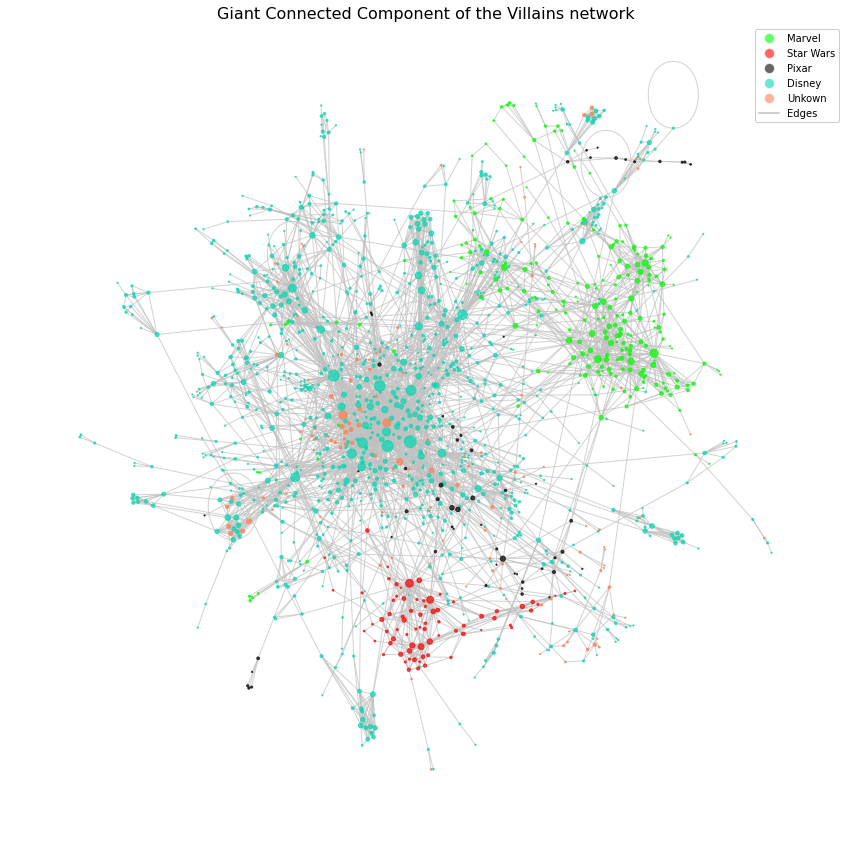

In [33]:
f = plt.figure(figsize=(15,15))
ax = plt.gca()

# Create a legend for the different colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Marvel',
                          markerfacecolor="#00FF00", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Star Wars',
                          markerfacecolor="#FF0000", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Pixar',
                          markerfacecolor="#000000", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Disney',
                          markerfacecolor="#04D8B2", markersize=10, alpha=0.6),
                   Line2D([0], [0], marker='o', color='w', label='Unkown',
                          markerfacecolor="#FF7F50", markersize=10, alpha=0.6),
                   Line2D([0], [0], color="#C0C0C0", label='Edges')]

positions = forceatlas2.forceatlas2_networkx_layout(gcc_undirected, pos=None, iterations=50)
nodes = nx.draw_networkx_nodes(gcc_undirected, positions, node_size=node_size, node_color=color_roles, alpha=0.7)
edges = nx.draw_networkx_edges(gcc_undirected, positions, edge_color=edge_colors,alpha=0.7)

plt.axis('off')
plt.title("Giant Connected Component of the Villains network", fontsize=16)

plt.legend(handles=legend_elements, facecolor='white', framealpha=1)

plt.show()

The figure above shows the whole Villains network, with different colors for all the five universes. On the figure we see that there are some groups that are better connected than others. Those groups represent the different universes. The Marvel universe is displayed with green color, Star Wars with red color, Pixar with gray color, Walt diseny with blue color and the villains who are not a part of a specific universe, are represented with pink color (Unknown). When looking at the graph, we see that the green nodes make a large, separated group, and we are interested in exploring that further.

In [34]:
# Make a network
marvel_network = nx.DiGraph()

# Add egdes
marvel_links = get_hyperlinks(marvel_df)
marvel_network.add_edges_from(marvel_links)

# Discard isolated nodes
marvel_network.remove_nodes_from(list(nx.isolates(marvel_network)))

In [35]:
# Extract the giant connected component
gcc_marvel = marvel_network.subgraph(max(nx.weakly_connected_components(marvel_network), key=len))

In [36]:
gcc_undirected_marvel = gcc_marvel.to_undirected()

In [37]:
degrees = [val for node,val in gcc_undirected_marvel.degree()]

# Scale node size according to degree
node_size = [i * 1.6 for i in degrees]

In [38]:
# Get color for Marvel nodes 
color_roles = []

for node in gcc_undirected_marvel.nodes():
    if node in marvel_df.name_of_villains.values:
        color_roles.append('#00FF00')

In [39]:
edge_colors = []
for u, v in gcc_undirected_marvel.edges():
    edge_colors.append("#C0C0C0")

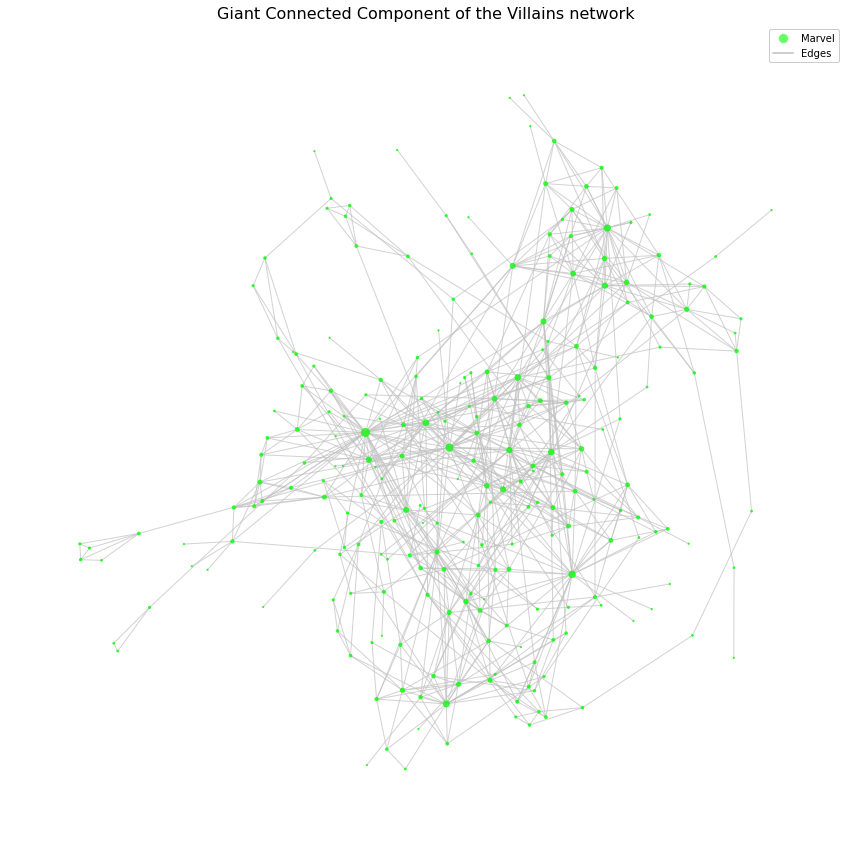

In [40]:
# Plot the Marvel network
f = plt.figure(figsize=(15,15))
ax = plt.gca()

# Create a legend for the different colors
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Marvel',
                          markerfacecolor="#00FF00", markersize=10, alpha=0.6),
                   Line2D([0], [0], color="#C0C0C0", label='Edges')]

positions = forceatlas2.forceatlas2_networkx_layout(gcc_undirected_marvel, pos=None, iterations=50)
nodes = nx.draw_networkx_nodes(gcc_undirected_marvel, positions, node_size=node_size, node_color=color_roles, alpha=0.7)
edges = nx.draw_networkx_edges(gcc_undirected_marvel, positions, edge_color=edge_colors,alpha=0.7)

plt.axis('off')
plt.title("Giant Connected Component of the Villains network", fontsize=16)

plt.legend(handles=legend_elements, facecolor='white', framealpha=1)

plt.show()

In [41]:
# Find the top 5 in-degree
top_indegree_marvel = sorted(dict(gcc_marvel.in_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 in-degree of the Villains network:\n', top_indegree_marvel[:5], '\n')
# Find the top 5 out-degree
top_outdegree_marvel = sorted(dict(gcc_marvel.out_degree()).items(), key=lambda item: item[1], reverse=True)
print('Top 5 out-degree of the Villains network:\n', top_outdegree_marvel[:5])

Top 5 in-degree of the Villains network:
 [('Loki Laufeyson', 32), ('Thanos', 30), ('Grant Ward', 21), ('Baron Zemo', 20), ('Kree', 18)] 

Top 5 out-degree of the Villains network:
 [('Loki Laufeyson', 23), ('Grant Ward', 20), ('Thanos', 18), ('Gideon Malick', 16), ('Amora the Enchantress', 15)]


# 3. Tools, theory and analysis <a class="anchor" id="chapter3"></a>

The following step-by-step approach was used to analyse each subsection of this chapter: 
* Explain what we're interested in
* Explain the tool
* Apply the tool
* Discuss the outcome

## 3.1 Communities <a class="anchor" id="section_3_1"></a>

### What we're interested in

We want to detect and partition the network into communities using a community detection algorithm. We then want to add the detected communities as node attributes to the network and save it as a csv file so that we can visualize the network in Gephi, which is a vialuzation tool that we will use later in this notebook. The results will then be put on the website. 

### Explain the tool

To gain more insights into the villan network, community detection is applied using the Louvain algorithm. This algorithm is used to extract communities from large networks. the Louvain algorithm uses a greedy optimization approach that optimizes modularity, resulting in the best feasible grouping of nodes in a network. Modularity measures the strenght of division of a network into communities. The value of modularity is in the range [-1/2, 1], and defined as: 

$
{\displaystyle Q={\frac {1}{2m}}\sum \limits _{ij}{\bigg [}A_{ij}-{\frac {k_{i}k_{j}}{2m}}{\bigg ]}\delta (c_{i},c_{j}),}
$

where:

* $A_{ij}$ represents the edge weight between nodes ${\displaystyle i}$ and ${\displaystyle j}$

* $k_{i}$ and $k_j$ are the sum of the weights of the edges attached to nodes ${\displaystyle i}$ and ${\displaystyle j}$, respectively

* $m$ is the sum of all of the edge weights in the graph

* $c_{i}$ and ${\displaystyle c_{j}}$ are the communities of the nodes

* $\delta$  is Kronecker delta function (${\displaystyle \delta (x,y)=1}$ if ${\displaystyle x=y}, {\displaystyle 0}$ otherwise).

Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules. [Ref: Modularity](https://en.wikipedia.org/wiki/Modularity_(networks))

Then the Louvain algorithm works in the following way:

1. Each node is first assigned to a community (i.e. each node is its community). The change in modularity is then computed for each node by removing it from its community and moving it into each of its neighbors' communities.

2. The nodes are then assigned to the communities where they last ended. The connections between the nodes are then used in the communities as weighted edges between the new nodes, and each community is treated as a single node. 

Then it starts again with the previously aggregated community as the new network. [Ref: Louvain_method](https://en.wikipedia.org/wiki/Louvain_method)

ATHATHATH : ANGELO skrifaði, viljum við tvinna þetta inn??????

The method used, compute the partition of the graph nodes which maximises the modularity using the Louvain heuristices. The algorithm initially creates random communities and then calculates their modularity. Then it optimizes the outcome by swaping nodes in different communities until there is no significant improvement of modularity. Then, all the nodes belonging to a community are merged into one giant node. The links that connect the giant nodes are the sum of the initial links. Then, the modularity is optimized again by clustering communities of communities and this is how the final communities are given.

### Apply the tool

#### Helper functions to get communities

* `communities`: Returns a list of lists with the name of every villain that are in each community.
* `get_list_with_size_of_communities`: Returns the community and the size of it.
* `get_top_communities`: Returns the top three connected villains for each community.

In [155]:
def communities(graph):
    partition = community.best_partition(graph)
    d = collections.defaultdict(list)
    # the community.best_partition function maps nodes to a community number, below we map 
    for com in set(partition.values()):
        for nodes in partition.keys():
            if partition[nodes] == com:
                d[com].append(nodes)
    return list(d.values())

In [157]:
def get_list_with_size_of_communities(marvel_communities):
    list_communities = []
    for com in marvel_communities:
        list_communities.append((len(com), com))
    return list_communities

In [159]:
def get_top_communities(list_communities):
    top_communities = []
    for i, j in list_communities:
        sorted_val = sorted(j, key=lambda x: gcc_marvel.degree(x), reverse=True)[:3]
        top_communities.append((i, sorted_val))
    sorted_top_communities = sorted(dict(top_communities).items())
    return sorted_top_communities

#### Finding the communities

In [156]:
marvel_communities = communities(gcc_undirected_marvel)
list_communities = get_list_with_size_of_communities(marvel_communities)
sorted_top_communities = get_top_communities(list_communities)

In [162]:
print('There are', len(marvel_communities), 'communities in total')

There are 11 communities in total


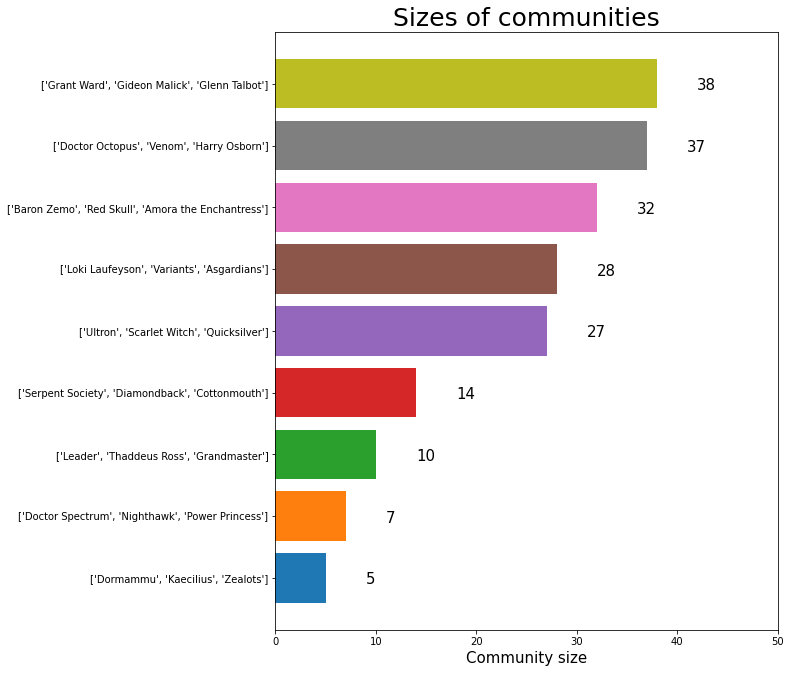

In [163]:
plt.figure(figsize=(9,11))
for value, names in sorted_top_communities:
    plt.barh(str(names), value)
    
for n,(value,index) in enumerate(sorted_top_communities):
    plt.text(value+4, n-0.1, str(value), fontsize=15)
    
plt.xlabel('Community size', fontsize = 15)
plt.title('Sizes of communities',fontsize=25)
plt.xlim(0,50);

### Discuss the outcome

ANGELOO SKRIFAÐI SKOÐA: 

Since this is a stochastic process, the communities will differ every time the algorithm is run, however we will be able to see specific patterns in relationships between charachters. For example, Scorpio and Dr. Octapus will always be in the same community with The Venom as thaey are the main antagonists of Spiderman. In the same manner, Red Skull will be with Bucky Barnes, while Loki with the Asgardians (as well as with Variations of Loki that are considered different characters).

## 3.2 Network visualization with Gephi <a class="anchor" id="section_3_2"></a>

### What we're interested in

We are interested in visualizing the network we have created and explore it further. We want to be able to examine the network in detail in order to perform exploratory analysis. This requires the ability to calculate relevant metrics for the network. 


In other words, we want to see clearly, the network from the following perspectives:

* Depending on the number of connections
* Depending on different communities
* Depending on betweeness centrality


Moreover, we would like to have an interactive figure to upload on our website.

### Explain the tool

The tool we used for the visulazation is called [Ref: Gephi](https://gephi.org/). Gephi is a network visualization and exploration tool that may be used with any type of network. This means that the tool can be used to explore a network and compute various properties. 

We imported our dataset into Gephi. Then we used the Circle Pack and ForceAtlas2 layouts to spatalize our undirected graph.

* Circle Pack: This layout allows us to group nodes according to their attributes and displays the nodes in a circle.

* ForceAtlas2: It's used to spatialize a weighted undirected graph in 2D. It is a force-directed layout, where edges attract their nodes, while nodes repel each other. 

### Apply the tool

#### Helper functions for visualization with gephi

* `dataframe_to_csv`: Loads the nodes and the egdes into csv file, in order to upload it to Gephi.

In [165]:
def dataframe_to_csv(marvel_df):
    marvel_df.to_csv('nodes.csv')

    marvel_links = get_hyperlinks(marvel_df)
    with open('egdes.csv','w') as out:
        csv_out=csv.writer(out)
    csv_out.writerow(['Source','Target'])
    for row in marvel_links:
        csv_out.writerow(row)

#### Visulazation ranked after degree

We ranked the nodes based on their degree, so bigger nodes have a higher degree, and vice versa. Then we colored the egdes and changed the layout until we were satisfied with the visulazation. This is displayed in the figure below.

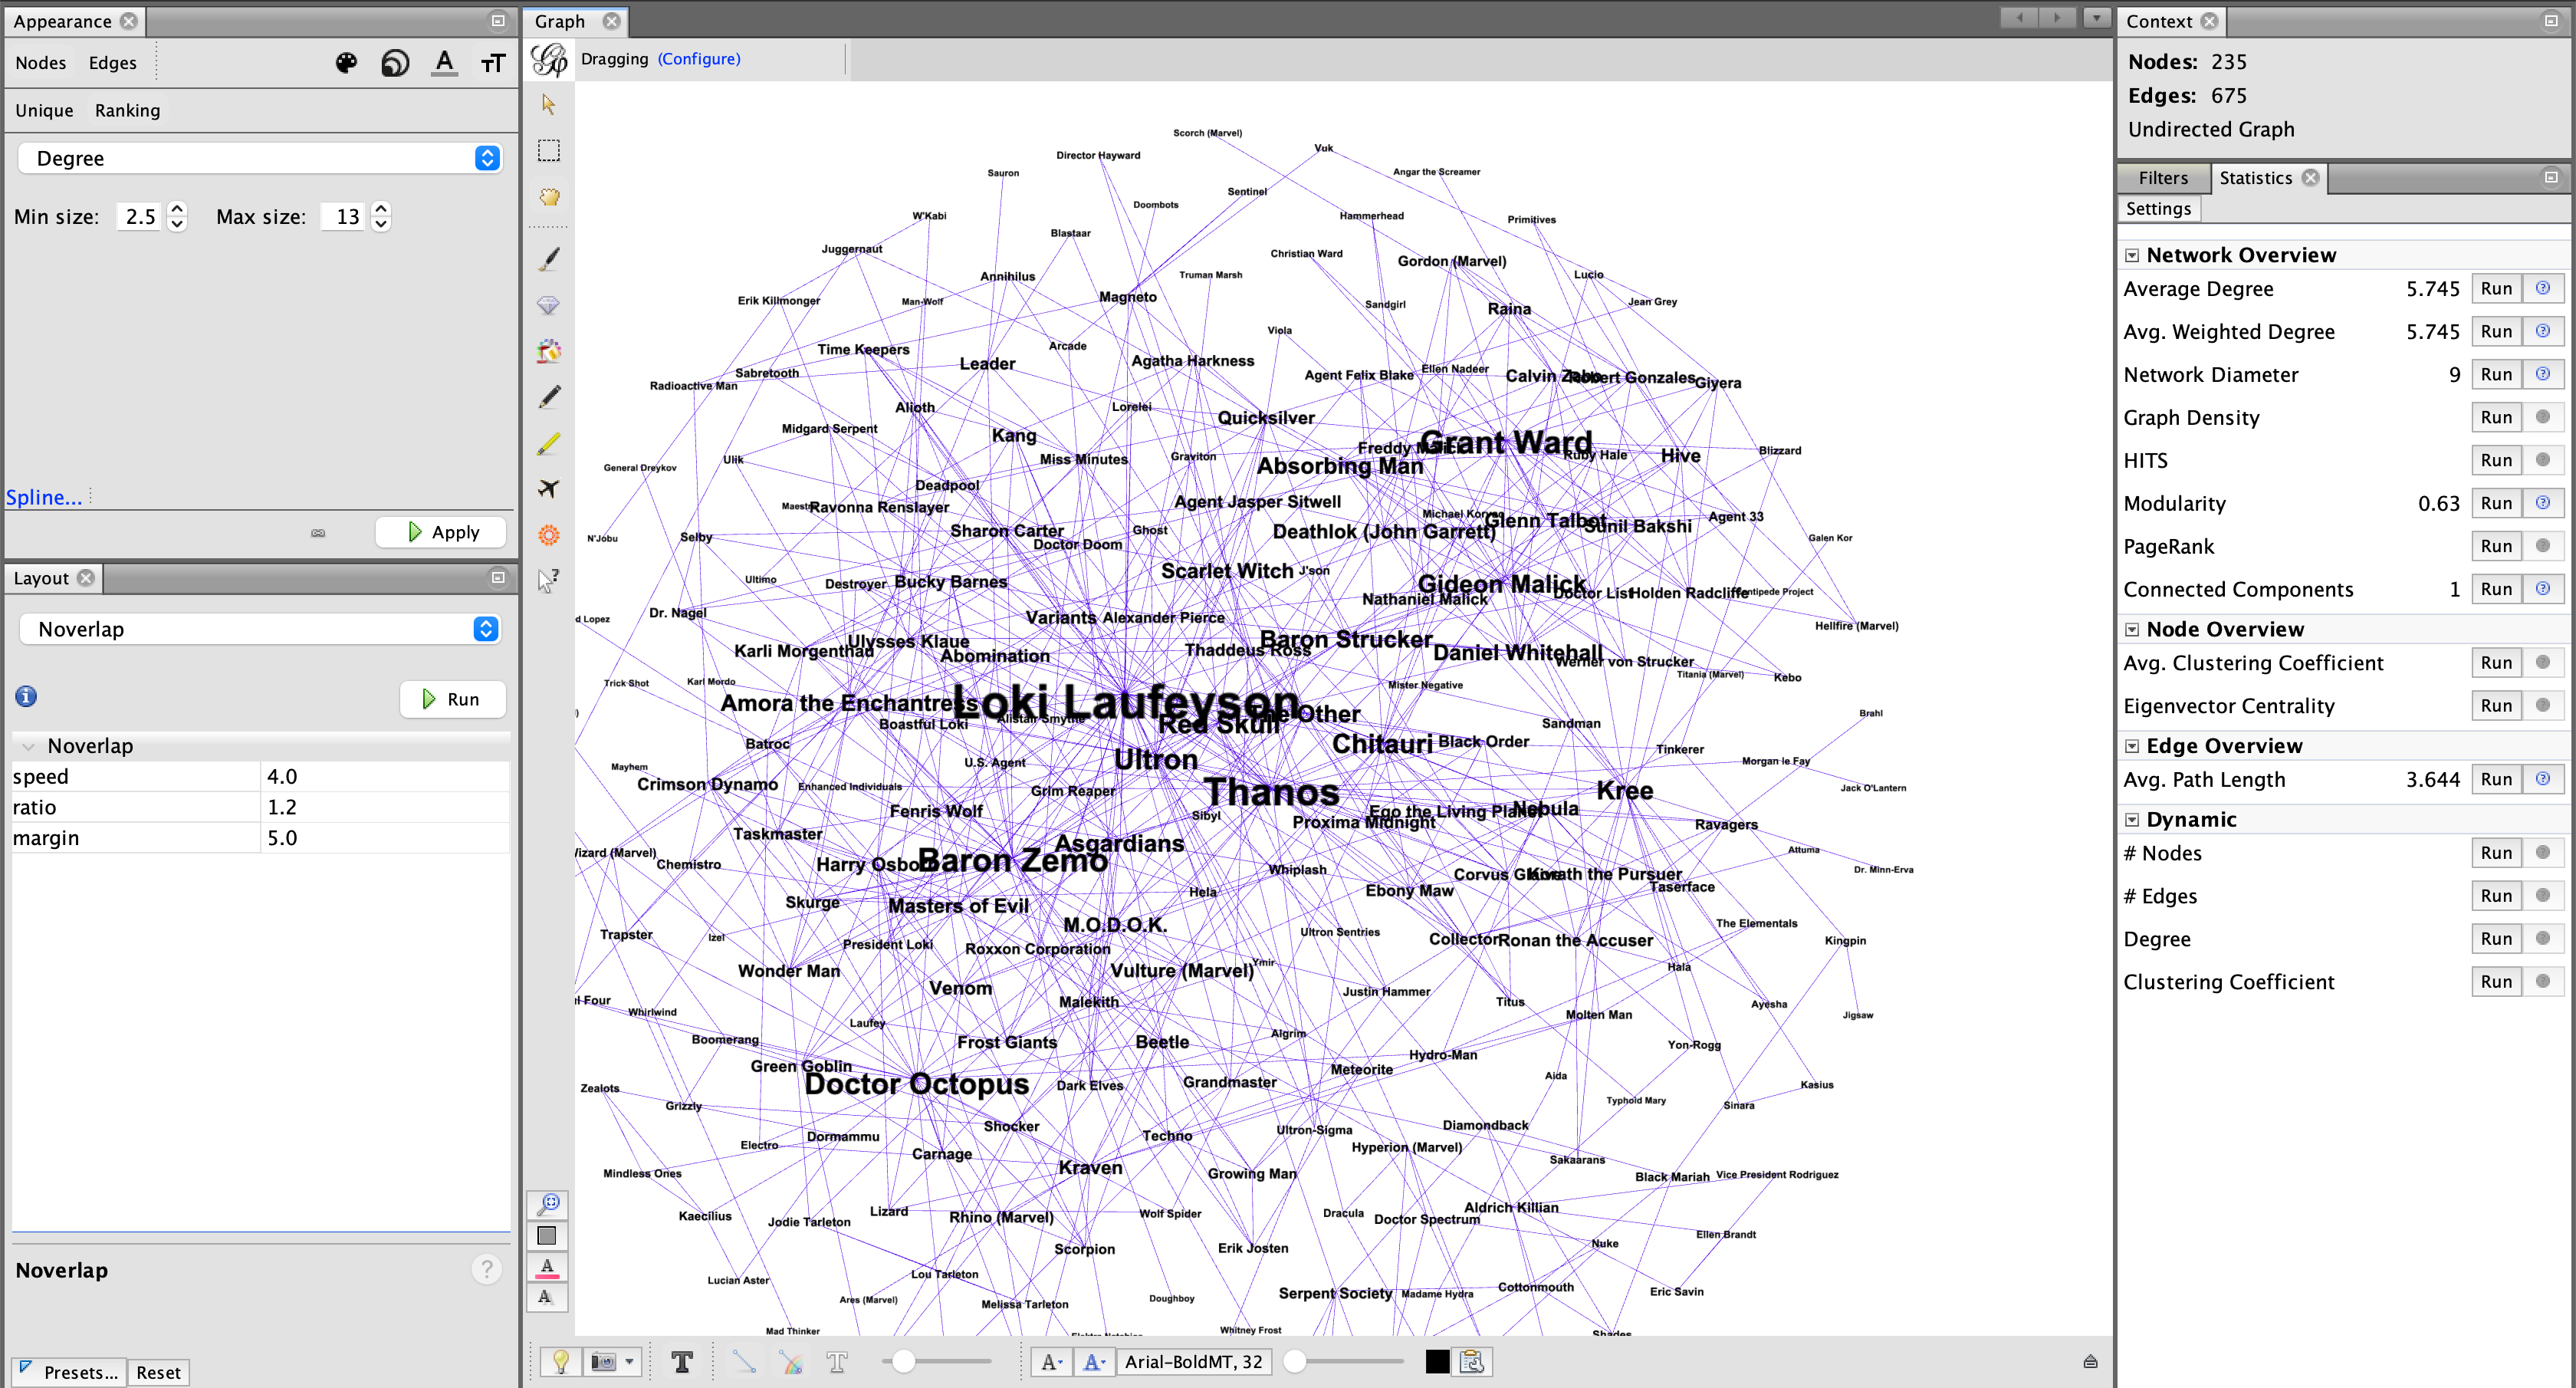

#### Visulazation with all communities

Furthermore, we used the previous mentioned csv file, that contained communities for each node in the network. Then we
colored the nodes based on their communities. The colors corresponding to each community can be seen in the left upper corner of the figure below.

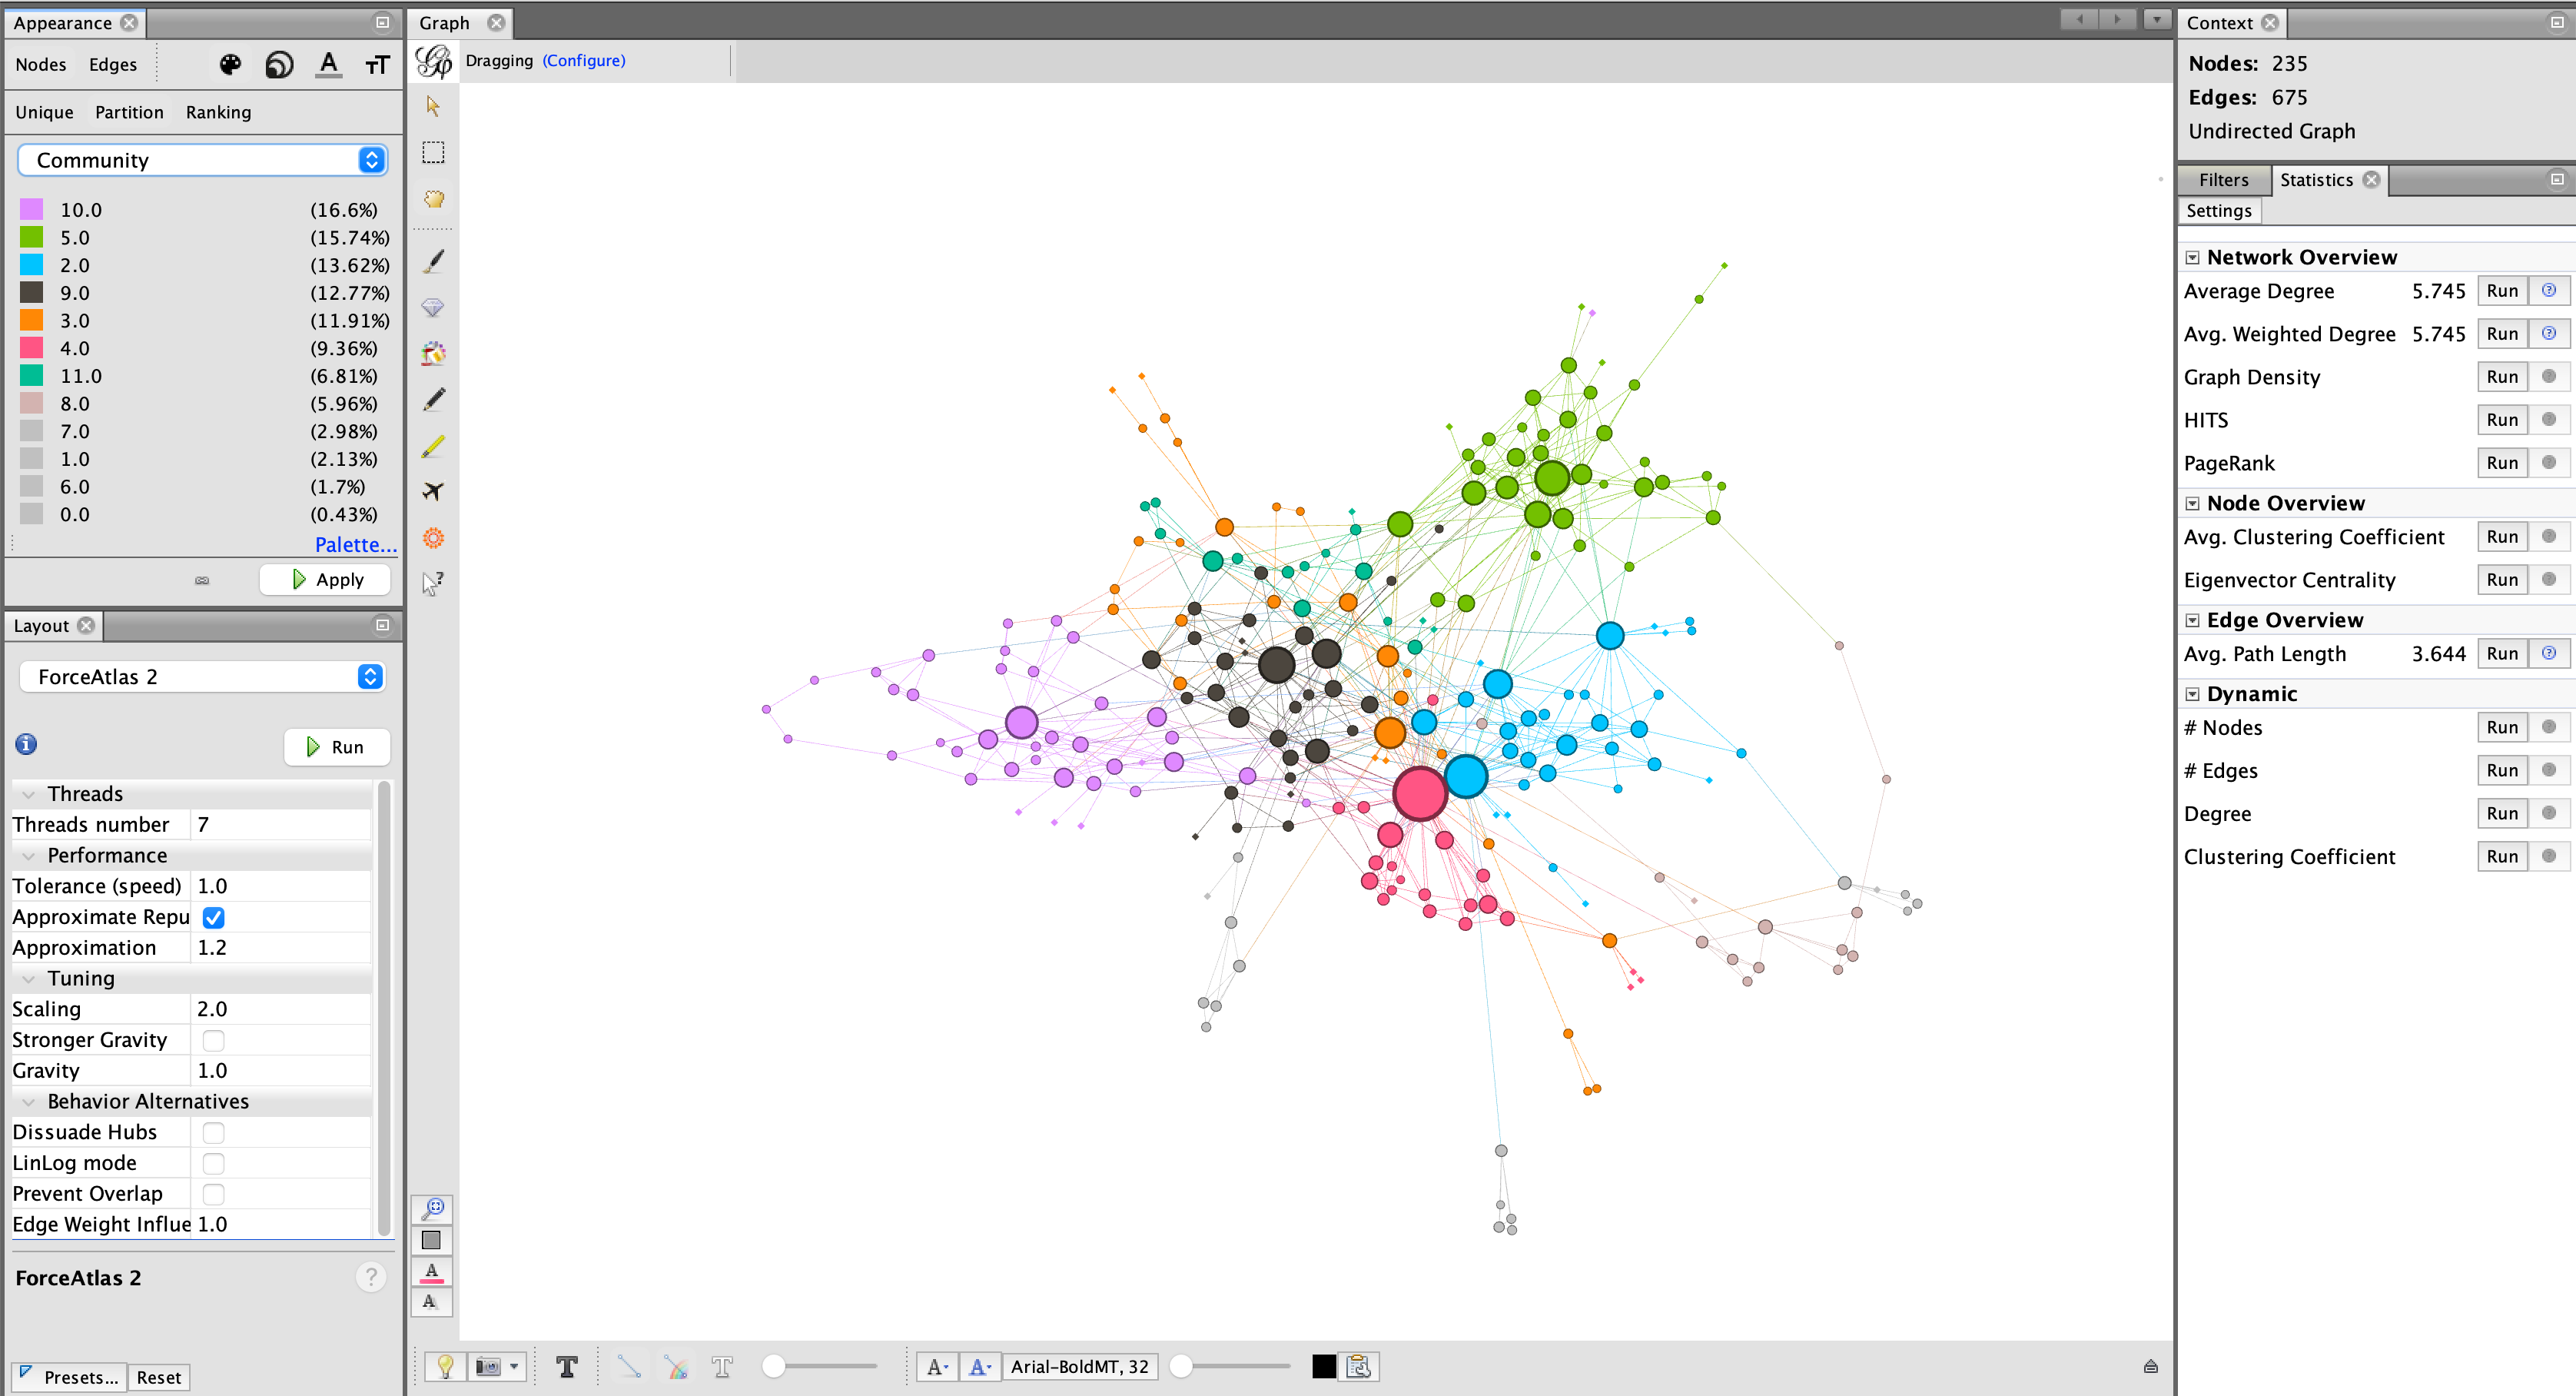

#### Visualazition ranked after betweeness centrality

Finally, we computed the betweenness centrality using the network diameter statistics that can be seen on the left of the figure below. Then the node size was changes according to the betweenness cantrality, so that the largest node had the highes betweenness centrality, and vice versa.

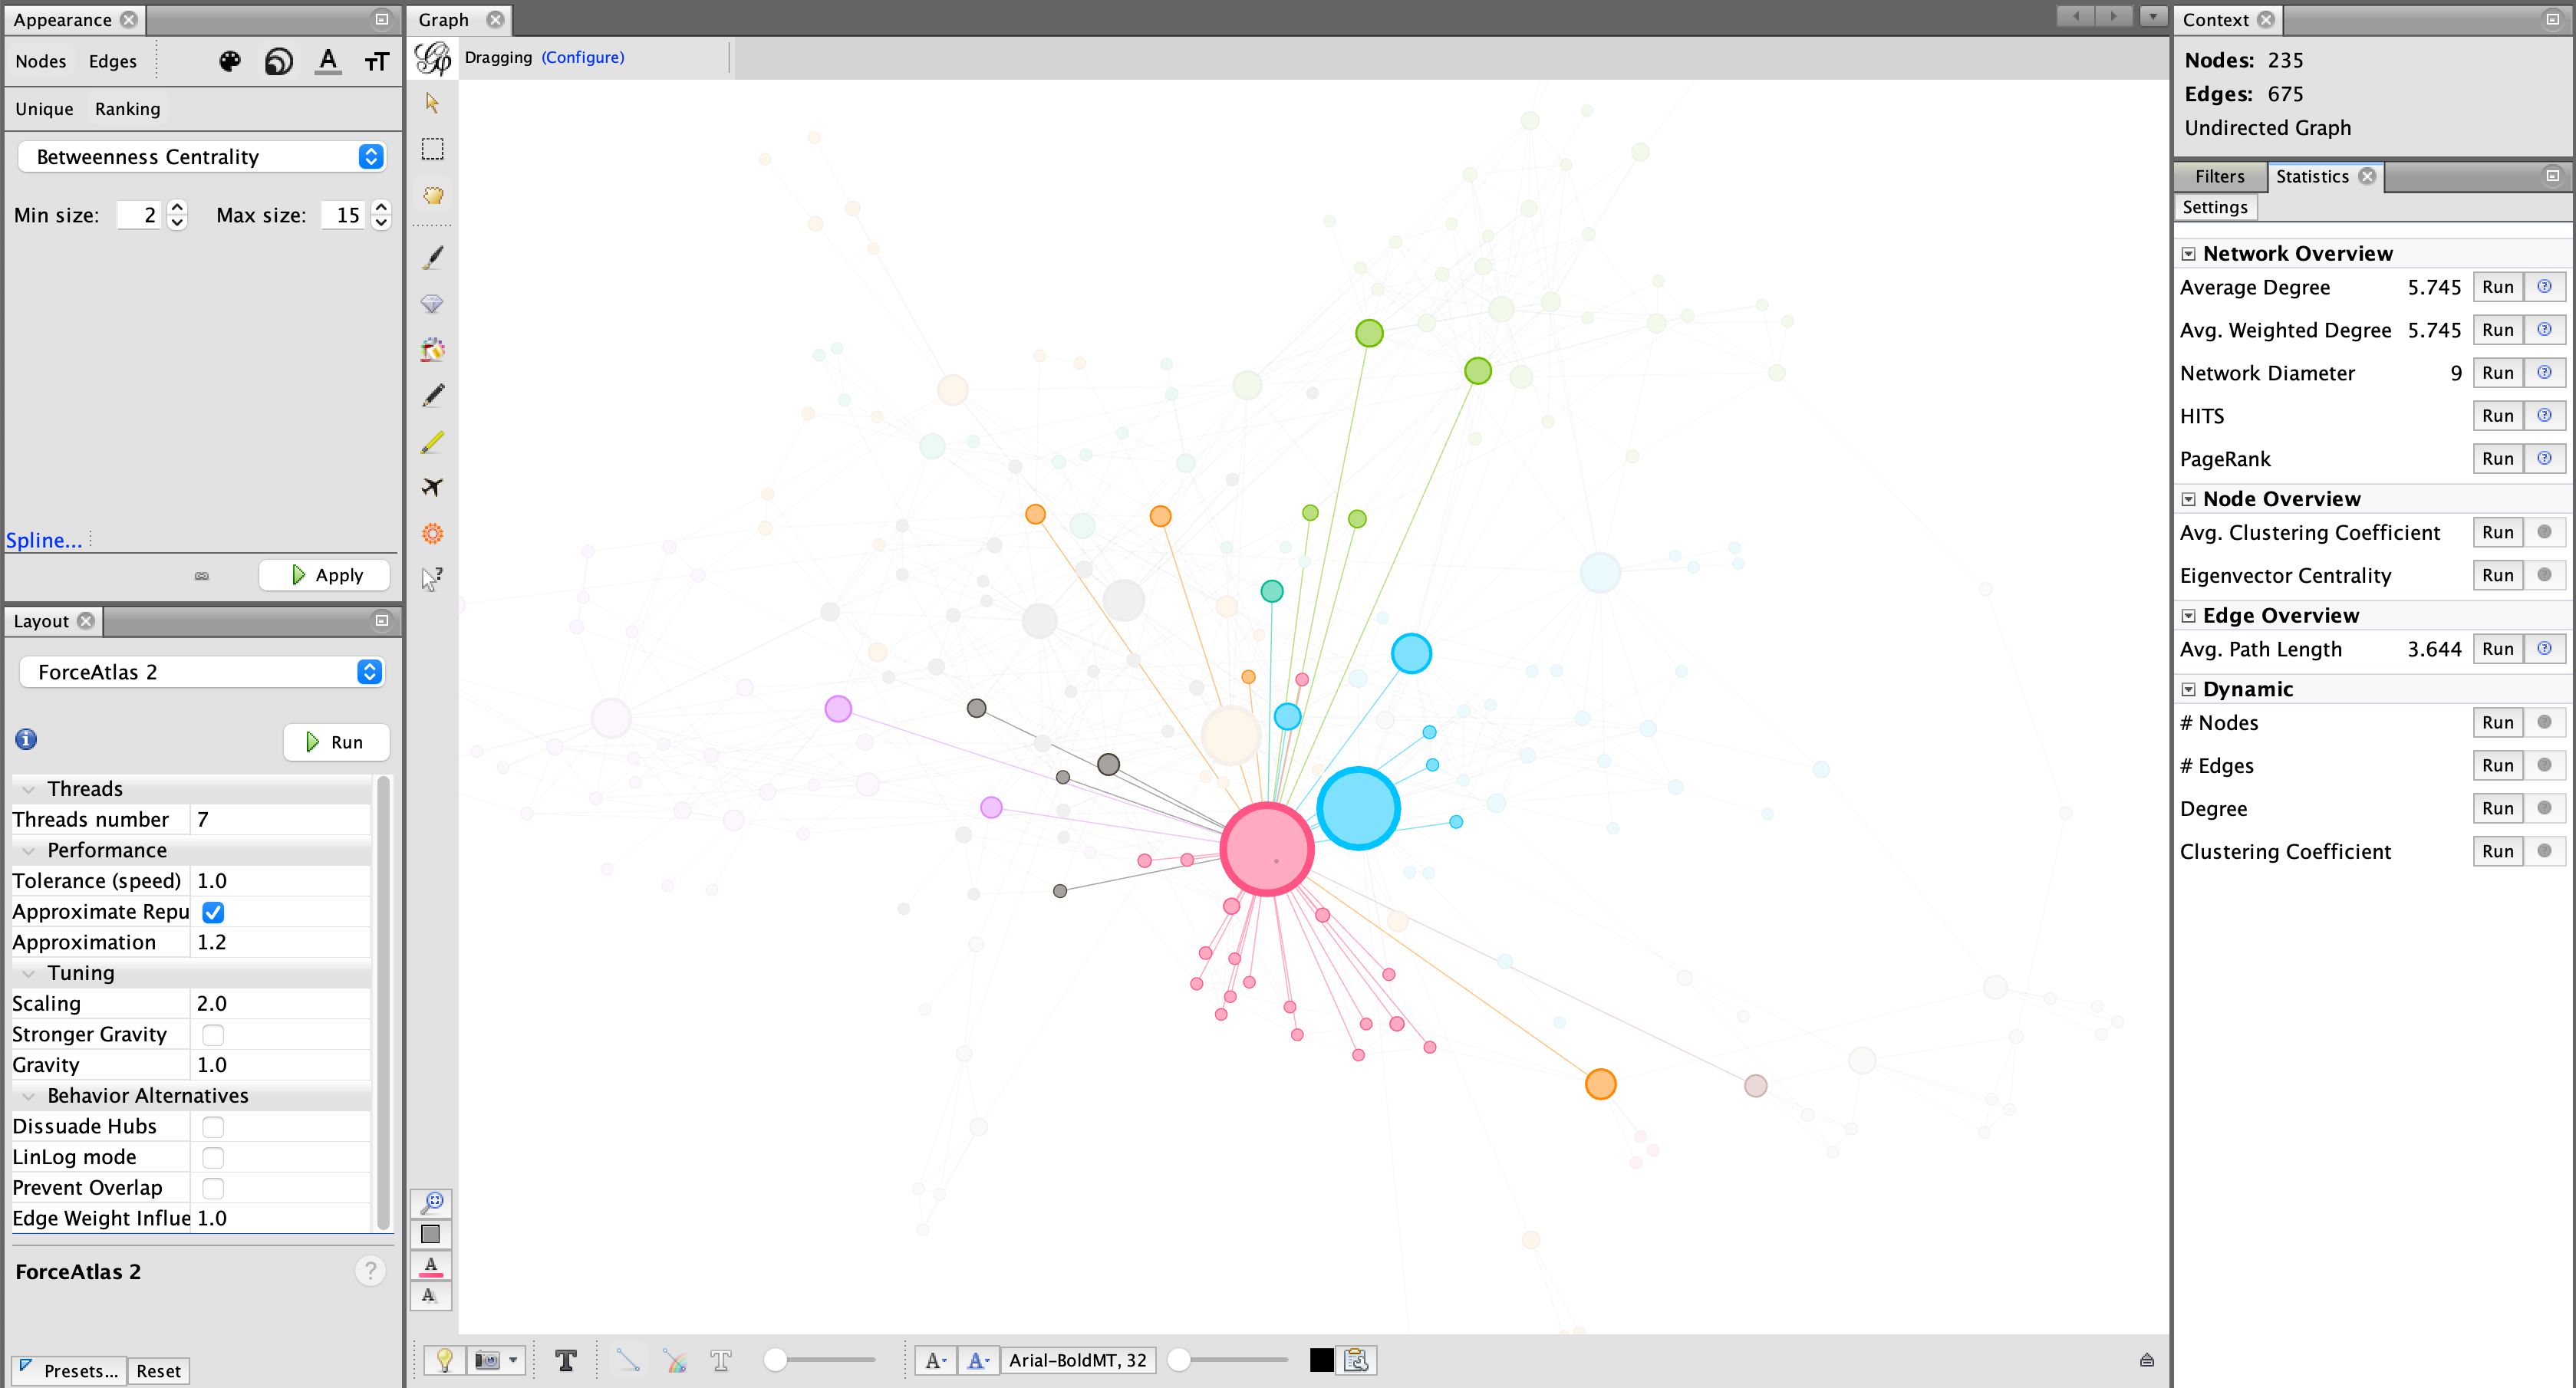

### Discuss the outcome

We were really satisfied with the results. We thought the tool visualized the network very well, and gave us a better intuition into the Marvel villains. 

We thought the graph that was ranked by degrees was very interesting. It explains the network well, and we can see clearly what characters are the most connected. With this we can get acquainted with the Marvel villains network.

When using Gephi, we found out that the node with the highest bewteenness centrality was Loki Laufeyjarson. Betweenness centrality measures the number of times a node appears on the shortest path between nodes. As a result, nodes with high betweenness play an important role in linking the entire network. Since they dominate the shortest paths bettween nodes, they may cause disruption in egdes between nodes if they are not present in the network. 

When the node size is adjusted according to the betweenness centrality, it can be determined which characters are the most essential in terms of connecting all of the network's villains. The network's largest nodes have the highest betweenness centrality, and hence operate as bridges between two areas of the network or as shortcuts between parts that are farther away.

Loki Laufeyjarson, as previously said, has the highest network betweenness centrality. This could indicate that Loki Laufeyjarson is connected to villains from several other communities.

## 3.3 Sentiment analysis <a class="anchor" id="section_3_3"></a>

### What we're interested in

We're interested in seeing how emotions are shown in every charachter text file and try to detect which character  convey more positive or negative emotions. Two separate features are used to explore the sentiment of the text content, LabMT wordlist and the sentiment analysis tool VADER.

### Explain the tool

*LabMT wordlist*

The tokenized words are classified using the LabMT wordlist. The list includes frequent words as well as their average happiness score, which can be used to provide a score to each character. 
All character text files are tokenized(cleaned) and the average happiness score is generated using the words contained in the LabMT wordlist. 

*VADER*

VADER is used to further analyze the description content of the happiest and saddest character. To familiarize ourselves with the traits that make a character happy or sad, we'd like to know the proportion of negative and positive phrases within each character file.

VADER is an NLTK sentiment analysis tool. The model is a lexicon and rule-based sentiment analysis tool which is sensitive to polarity, i.e., positive/negative, and the intensity of emotion. Within each character file, the proportion of positive, negative, and neutral words is found, i.e., the sum of the positive, negative, and neutral scores is equal to 1 for character.

Positive emotions are expressed through words like "love" and "happy." It can also identify basic contexts, such as "not happy" being classified as a negative phrase.

### Apply the tool

### Discuss the outcome

## 3.4 TF-IDF <a class="anchor" id="section_3_4"></a>

## 3.5 Word-clouds <a class="anchor" id="section_3_5"></a>

In [55]:
#create dataframe from dictionary to use for the wordcloud
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in dict_of_universes.items() })
dict_df = dict_df.T

# merge all columns with strings to one column with all the strings
df_w = pd.Series(dict_df.fillna('').values.tolist()).str.join(' ')
df_w = df_w.to_frame()

df_w['universe'] = universe_list
df_w = df_w.rename(columns={0: 'description'})

In [56]:
star_wars_mask = np.array(Image.open('starwars.jpeg'))
marvel_mask = np.array(Image.open('marvel.jpeg'))
pixar_mask = np.array(Image.open('pixar.png'))
disney_mask = np.array(Image.open('disney.jpeg'))

In [57]:
# Define wordcloud function to use for each of the races
def show_wordcloud(df_w, title, pic):
    text = ' '.join(df_w['description'].astype(str).tolist()) 
    #crete list of strings
    stopwords = set(wordcloud.STOPWORDS) #set stopwords, taken from library
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords, colormap=sns.color_palette("hls", 8, as_cmap=True),
        max_font_size=100, max_words=200, mask=pic, background_color="white", contour_width=1, contour_color='black').generate(text)
    
    #nr of words included, size of biggest word etc..
    plt.figure(figsize=(8, 8), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear") 
    plt.axis('off')
    plt.title(title, fontsize=15)
    plt.show()

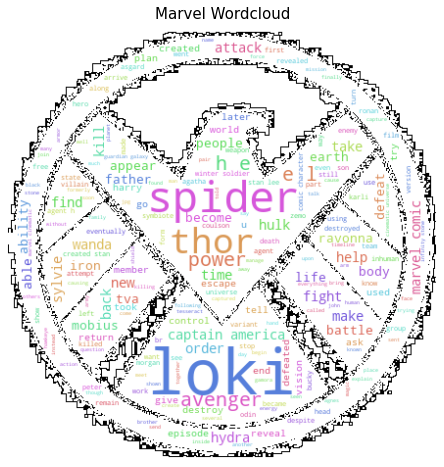

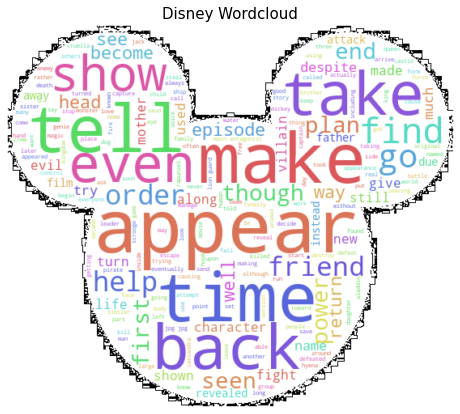

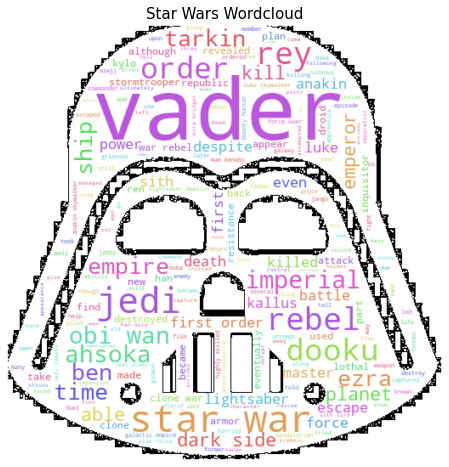

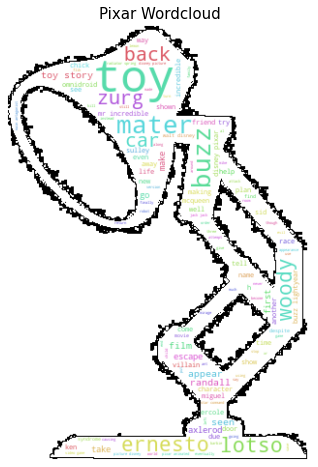

In [58]:
show_wordcloud(df_w[df_w.universe=='Marvel'], "Marvel Wordcloud", marvel_mask)
show_wordcloud(df_w[df_w.universe=='Disney'], "Disney Wordcloud", disney_mask)
#show_wordcloud(df_w[df_w.universe=='Unkown'], "Unkown Wordcloud", star_wars_mask)
show_wordcloud(df_w[df_w.universe=='Star Wars'], "Star Wars Wordcloud", star_wars_mask)
show_wordcloud(df_w[df_w.universe=='Pixar'], "Pixar Wordcloud", pixar_mask)

## 4. Discussion <a class="anchor" id="chapter4"></a>

## 5. Reference <a class="anchor" id="chapter5"></a>

[1] Wikipedia contributors. (2021a, December 1). Modularity (networks). Wikipedia.             https://en.wikipedia.org/wiki/Modularity_(networks)

[2] Wikipedia contributors. (2021, December 1). Tf–idf. Wikipedia. https://en.wikipedia.org/wiki/Tf%E2%80%93idf

## 6. Contributions <a class="anchor" id="chapter6"></a>